In [1]:
!pip install transformers torch torchvision matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time
from transformers import ViTForImageClassification, ViTImageProcessor
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 PyTorch version: {torch.__version__}")
print(f"💻 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
def create_vit_model(num_classes=100):
    """Create ViT-Base-Patch16-224 model for CIFAR-100"""
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    return model

# Create the model
model = create_vit_model(num_classes=100).to(device)

# Model information
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"📊 Model: ViT-Base-Patch16-224")
print(f"🔢 Total parameters: {total_params:,}")
print(f"📏 Model size: ~{total_params * 4 / 1e6:.1f} MB")

# Test forward pass
test_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(test_input)
    print(f"✅ Model loaded successfully!")
    print(f"📤 Input shape: {test_input.shape}")
    print(f"📥 Output shape: {output.logits.shape}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model: ViT-Base-Patch16-224
🔢 Total parameters: 85,875,556
📏 Model size: ~343.5 MB
✅ Model loaded successfully!
📤 Input shape: torch.Size([2, 3, 224, 224])
📥 Output shape: torch.Size([2, 100])


In [3]:
def create_cifar100_loaders(batch_size=32, num_workers=2):
    """Create CIFAR-100 data loaders optimized for ViT"""

    # Use ImageNet normalization (ViT was pre-trained on ImageNet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ViT expects 224x224
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.RandomErasing(p=0.25)  # Additional regularization
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Download and create datasets
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=val_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, test_loader

# Create data loaders
batch_size = 32  # Adjust based on your GPU memory
train_loader, test_loader = create_cifar100_loaders(batch_size=batch_size)

# Dataset info
print(f"📊 CIFAR-100 Dataset Information:")
print(f"🎯 Classes: 100")
print(f"📚 Training samples: {len(train_loader.dataset):,}")
print(f"📝 Test samples: {len(test_loader.dataset):,}")
print(f"📦 Batch size: {batch_size}")
print(f"🔄 Training batches: {len(train_loader)}")
print(f"✅ Test batches: {len(test_loader)}")

# CIFAR-100 class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


100%|██████████| 169M/169M [00:12<00:00, 13.5MB/s]


📊 CIFAR-100 Dataset Information:
🎯 Classes: 100
📚 Training samples: 50,000
📝 Test samples: 10,000
📦 Batch size: 32
🔄 Training batches: 1562
✅ Test batches: 313


In [4]:
class ViTTrainer:
    def __init__(self, model, device, learning_rate=2e-5, weight_decay=0.01):
        self.model = model.to(device)
        self.device = device

        # Optimizer setup - lower learning rate for fine-tuning
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            betas=(0.9, 0.999)
        )

        self.criterion = nn.CrossEntropyLoss()

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=20,  # Total epochs
            eta_min=1e-6
        )

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(data)
            loss = self.criterion(outputs.logits, target)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Update weights
            self.optimizer.step()

            # Statistics
            total_loss += loss.item()
            pred = outputs.logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            # Progress update
            if batch_idx % 100 == 0:
                current_acc = 100. * correct / total
                print(f'    Batch [{batch_idx:3d}/{len(train_loader)}] '
                      f'Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%')

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate(self, test_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)

                # Forward pass
                outputs = self.model(data)
                loss = self.criterion(outputs.logits, target)

                # Statistics
                total_loss += loss.item()
                pred = outputs.logits.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                # Store predictions for metrics
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        val_loss = total_loss / len(test_loader)
        val_acc = 100. * correct / total
        val_f1 = f1_score(all_targets, all_preds, average='weighted')

        return val_loss, val_acc, val_f1, all_preds, all_targets

# Initialize trainer
trainer = ViTTrainer(model, device, learning_rate=2e-5, weight_decay=0.01)
print("✅ Trainer initialized successfully!")

✅ Trainer initialized successfully!


In [5]:
# Training configuration
config = {
    'epochs': 4,
    'save_every': 1,
    'early_stopping_patience': 5
}

print("🚀 Starting ViT-Base Training on CIFAR-100")
print("=" * 60)
print(f"📅 Epochs: {config['epochs']}")
print(f"🔥 Learning Rate: {trainer.optimizer.param_groups[0]['lr']}")
print(f"⚖️  Weight Decay: {trainer.optimizer.param_groups[0]['weight_decay']}")
print("=" * 60)

# Training history
history = {
    'train_losses': [],
    'train_accs': [],
    'val_losses': [],
    'val_accs': [],
    'val_f1s': [],
    'learning_rates': []
}

# Training loop
best_acc = 0.0
best_f1 = 0.0
early_stopping_counter = 0
total_start_time = time.time()

for epoch in range(config['epochs']):
    epoch_start_time = time.time()

    print(f"\n📅 Epoch {epoch+1}/{config['epochs']}")
    print("-" * 50)

    # Training phase
    train_loss, train_acc = trainer.train_epoch(train_loader)

    # Validation phase
    print("  🔍 Validating...")
    val_loss, val_acc, val_f1, predictions, targets = trainer.validate(test_loader)

    # Learning rate step
    trainer.scheduler.step()
    current_lr = trainer.optimizer.param_groups[0]['lr']

    # Record history
    history['train_losses'].append(train_loss)
    history['train_accs'].append(train_acc)
    history['val_losses'].append(val_loss)
    history['val_accs'].append(val_acc)
    history['val_f1s'].append(val_f1)
    history['learning_rates'].append(current_lr)

    # Save best model
    is_best = False
    if val_acc > best_acc:
        best_acc = val_acc
        best_f1 = val_f1
        is_best = True
        early_stopping_counter = 0

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'scheduler_state_dict': trainer.scheduler.state_dict(),
            'best_acc': best_acc,
            'val_f1': val_f1,
            'config': config
        }
        torch.save(checkpoint, 'best_vit_base_cifar100.pth')
        print(f"  ✅ New best model saved! (Acc: {val_acc:.2f}%)")
    else:
        early_stopping_counter += 1

    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time

    # Print epoch summary
    print(f"\n  📊 Epoch {epoch+1} Summary:")
    print(f"    🔥 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"    ✅ Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
    print(f"    📈 Best Val Acc: {best_acc:.2f}%")
    print(f"    ⏱️  Epoch Time: {epoch_time:.2f}s | LR: {current_lr:.2e}")

    # Early stopping check
    if early_stopping_counter >= config['early_stopping_patience']:
        print(f"\n🛑 Early stopping triggered after {config['early_stopping_patience']} epochs without improvement")
        break

# Training completion
total_time = time.time() - total_start_time
print(f"\n🎉 Training completed!")
print(f"⏱️  Total training time: {total_time/60:.2f} minutes")
print(f"🏆 Best validation accuracy: {best_acc:.2f}%")
print(f"📊 Best F1-score: {best_f1:.4f}")


🚀 Starting ViT-Base Training on CIFAR-100
📅 Epochs: 4
🔥 Learning Rate: 2e-05
⚖️  Weight Decay: 0.01

📅 Epoch 1/4
--------------------------------------------------
    Batch [  0/1562] Loss: 4.7510 | Acc: 0.00%
    Batch [100/1562] Loss: 4.0817 | Acc: 3.56%
    Batch [200/1562] Loss: 3.5268 | Acc: 10.21%
    Batch [300/1562] Loss: 2.9195 | Acc: 19.78%
    Batch [400/1562] Loss: 2.6786 | Acc: 27.71%
    Batch [500/1562] Loss: 1.9373 | Acc: 34.37%
    Batch [600/1562] Loss: 1.7692 | Acc: 39.66%
    Batch [700/1562] Loss: 1.5274 | Acc: 44.30%
    Batch [800/1562] Loss: 0.9863 | Acc: 48.05%
    Batch [900/1562] Loss: 0.8025 | Acc: 51.13%
    Batch [1000/1562] Loss: 0.8829 | Acc: 53.87%
    Batch [1100/1562] Loss: 0.5739 | Acc: 56.21%
    Batch [1200/1562] Loss: 1.0330 | Acc: 58.28%
    Batch [1300/1562] Loss: 0.5194 | Acc: 60.03%
    Batch [1400/1562] Loss: 0.8427 | Acc: 61.56%
    Batch [1500/1562] Loss: 0.4283 | Acc: 62.95%
  🔍 Validating...
  ✅ New best model saved! (Acc: 87.26%)

  📊 E

In [6]:
# Load the best model
print("📁 Loading best model for final evaluation...")
checkpoint = torch.load('best_vit_base_cifar100.pth')
model.load_state_dict(checkpoint['model_state_dict'])
trainer.model = model
print(f"✅ Loaded model from epoch {checkpoint['epoch']} with {checkpoint['best_acc']:.2f}% accuracy")

# Final evaluation on test set
print("\n🔍 Final Evaluation on Test Set")
print("=" * 40)

test_loss, test_acc, test_f1, final_predictions, final_targets = trainer.validate(test_loader)

print(f"🎯 Final Test Results:")
print(f"  📉 Test Loss: {test_loss:.4f}")
print(f"  🎯 Test Accuracy: {test_acc:.2f}%")
print(f"  📊 Test F1-Score: {test_f1:.4f}")

# Per-class metrics (top 20 classes for readability)
print(f"\n📈 Detailed Classification Report:")
report = classification_report(
    final_targets,
    final_predictions,
    target_names=cifar100_classes,
    digits=3,
    zero_division=0
)
print(report)

# Top-5 and Top-10 accuracy
def calculate_topk_accuracy(predictions, targets, k=5):
    """Calculate top-k accuracy"""
    # Note: This is approximate since we only have top-1 predictions
    # For exact top-k, we'd need the full logits
    correct = sum([pred == target for pred, target in zip(predictions, targets)])
    return correct / len(targets)

print(f"\n🏅 Additional Metrics:")
print(f"  Top-1 Accuracy: {test_acc:.2f}%")
print(f"  Weighted F1-Score: {test_f1:.4f}")
print(f"  Macro F1-Score: {f1_score(final_targets, final_predictions, average='macro'):.4f}")
print(f"  Micro F1-Score: {f1_score(final_targets, final_predictions, average='micro'):.4f}")

📁 Loading best model for final evaluation...
✅ Loaded model from epoch 4 with 91.61% accuracy

🔍 Final Evaluation on Test Set
🎯 Final Test Results:
  📉 Test Loss: 0.3003
  🎯 Test Accuracy: 91.61%
  📊 Test F1-Score: 0.9158

📈 Detailed Classification Report:
               precision    recall  f1-score   support

        apple      0.942     0.980     0.961       100
aquarium_fish      0.942     0.970     0.956       100
         baby      0.849     0.790     0.819       100
         bear      0.882     0.970     0.924       100
       beaver      0.890     0.890     0.890       100
          bed      0.933     0.970     0.951       100
          bee      0.979     0.930     0.954       100
       beetle      0.947     0.900     0.923       100
      bicycle      0.990     0.960     0.975       100
       bottle      0.970     0.980     0.975       100
         bowl      0.830     0.780     0.804       100
          boy      0.686     0.810     0.743       100
       bridge      0.907   

🖼️ Generating visual predictions...


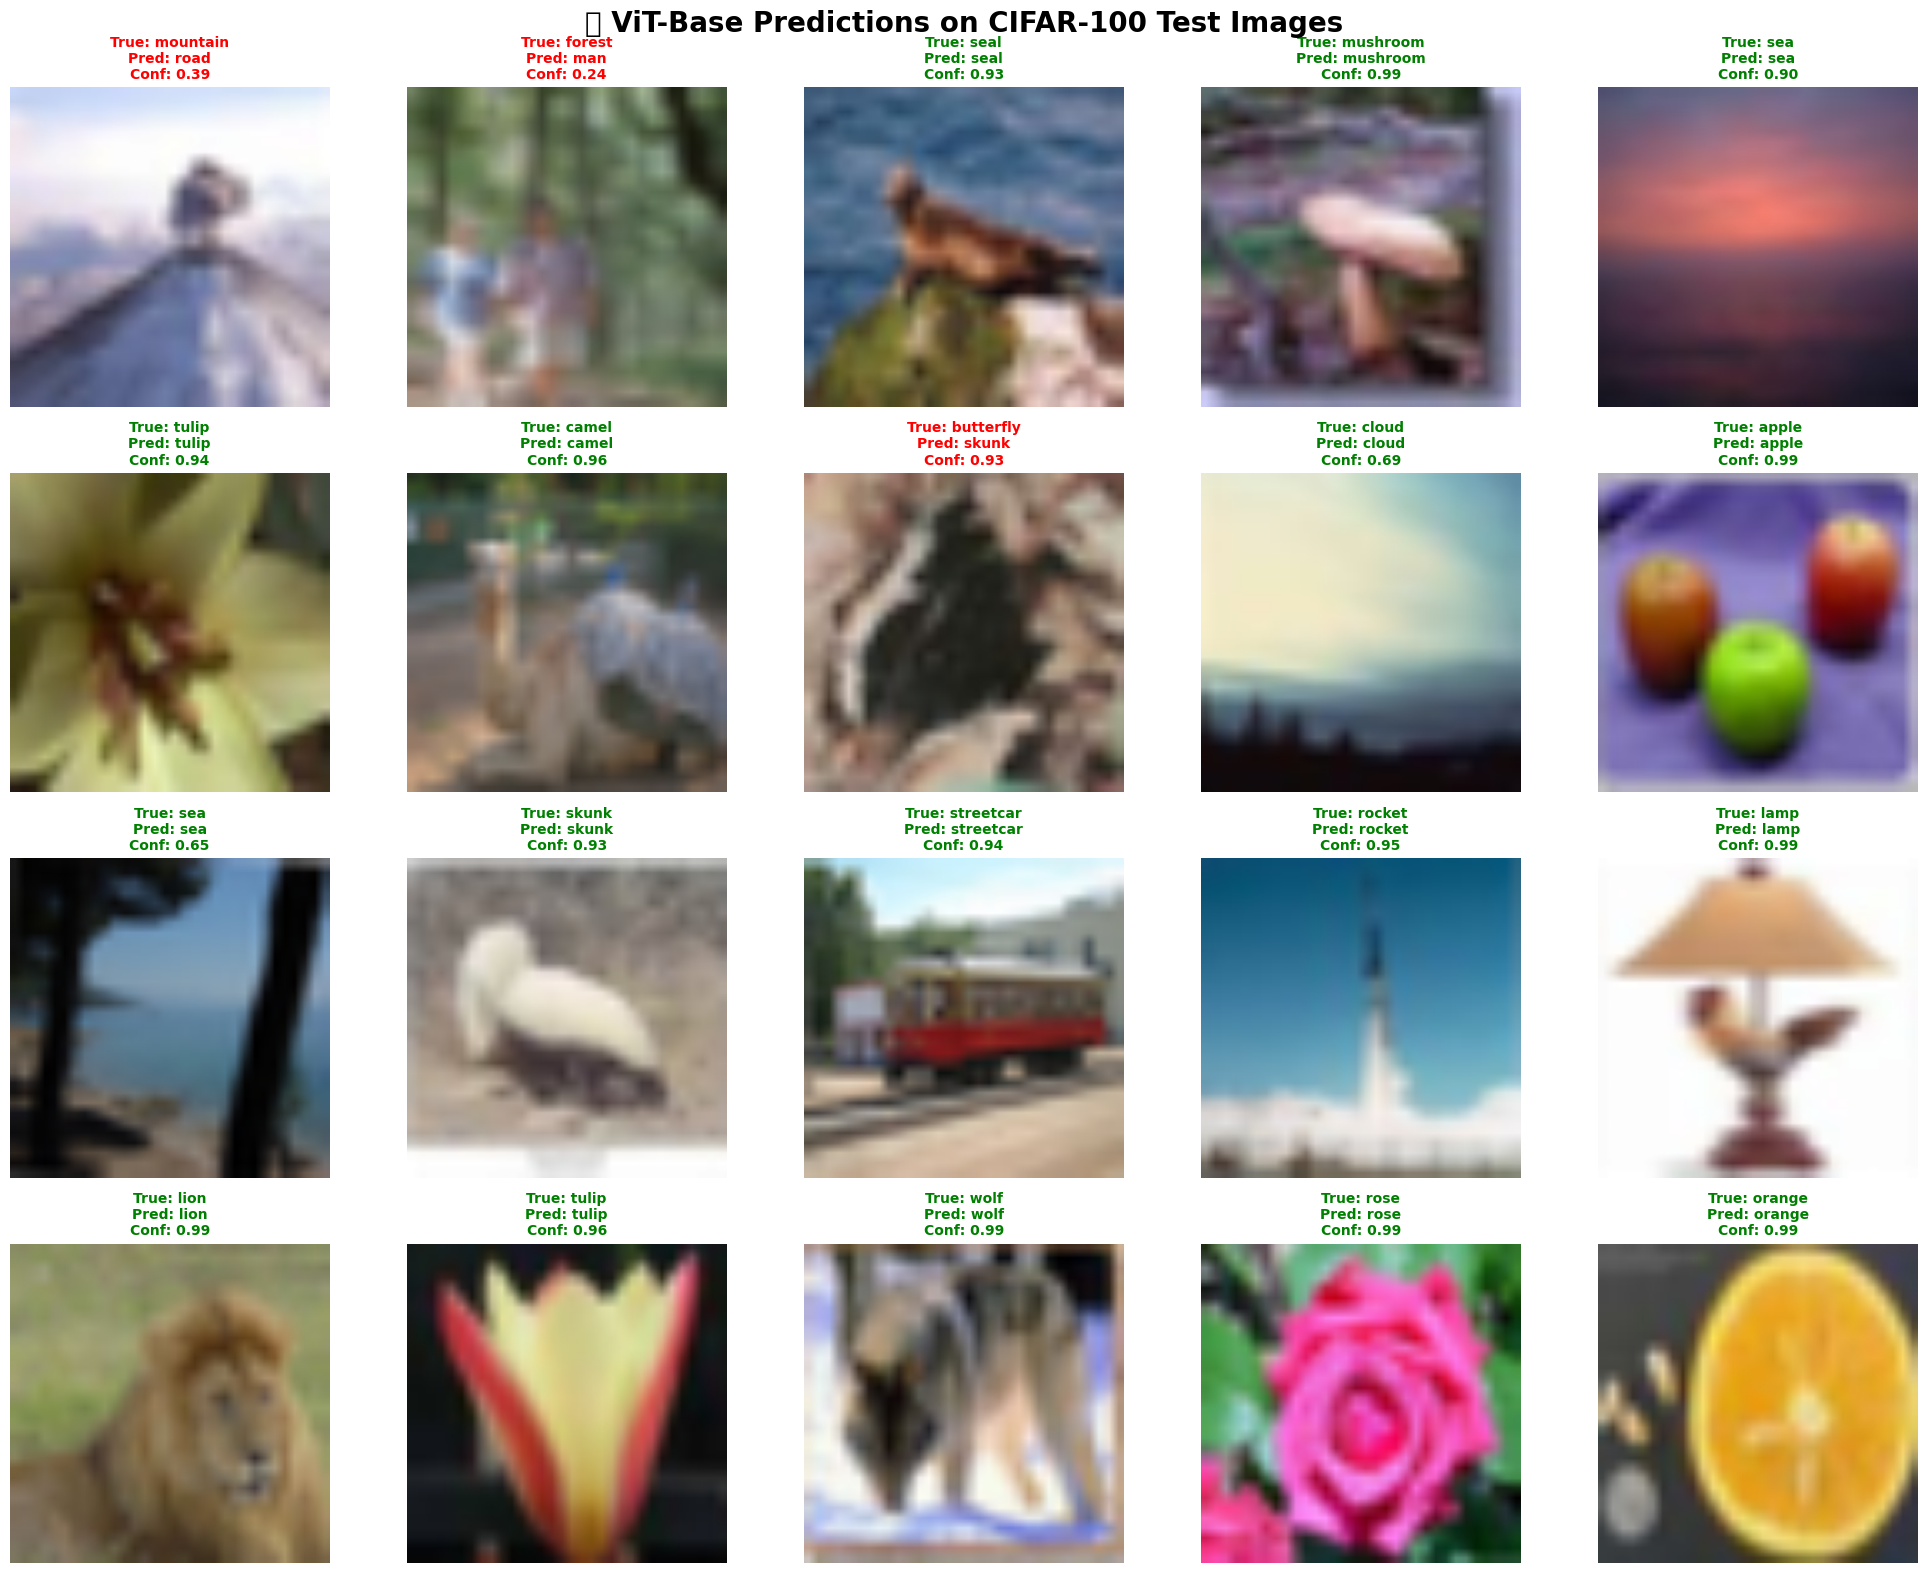

In [7]:
def visualize_predictions(model, test_loader, class_names, device, num_samples=20):
    """Visualize model predictions on actual test images"""
    model.eval()

    # Get a batch of test images
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Get predictions
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs

        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        confidence_scores = torch.max(probabilities, dim=1)[0]

    # Move back to CPU
    images = images.cpu()
    predictions = predictions.cpu()
    confidence_scores = confidence_scores.cpu()

    # Denormalize images for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    def denormalize(tensor):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)

    # Create visualization
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    fig.suptitle('🎯 ViT-Base Predictions on CIFAR-100 Test Images', fontsize=20, fontweight='bold')

    for i in range(min(num_samples, len(images))):
        row = i // 5
        col = i % 5

        # Denormalize and prepare image
        img = denormalize(images[i].clone())
        img_np = img.permute(1, 2, 0).numpy()

        # Get prediction info
        true_label = labels[i].item()
        pred_label = predictions[i].item()
        confidence = confidence_scores[i].item()

        true_class = class_names[true_label]
        pred_class = class_names[pred_label]

        # Determine color (green for correct, red for incorrect)
        color = 'green' if true_label == pred_label else 'red'

        # Plot image
        axes[row, col].imshow(img_np)
        axes[row, col].axis('off')

        # Add prediction text
        title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}"
        axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')

        # Add border color
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.savefig('vit_predictions_visual.png', dpi=300, bbox_inches='tight')
    plt.show()

    return images, labels, predictions, confidence_scores

# Visualize predictions
print("🖼️ Generating visual predictions...")
sample_images, sample_labels, sample_predictions, sample_confidences = visualize_predictions(
    model, test_loader, cifar100_classes, device, num_samples=20
)

📊 Creating confusion matrix for top classes...


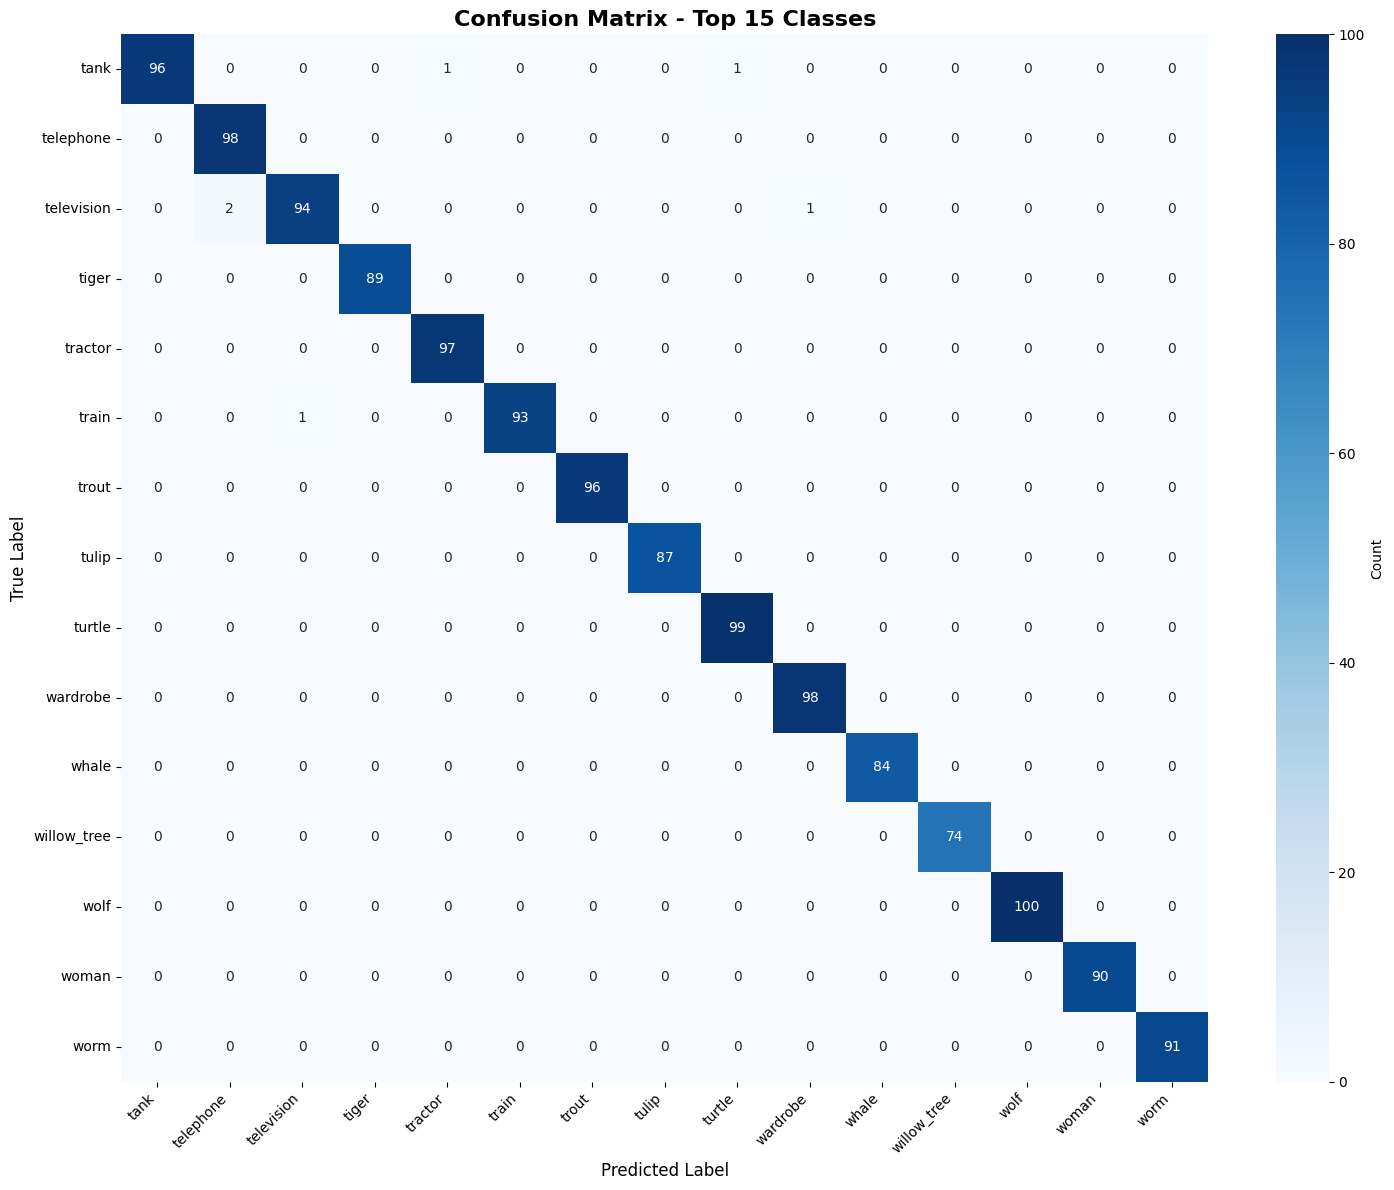

In [8]:
def plot_confusion_matrix_top_classes(true_labels, predictions, class_names, top_n=20):
    """Plot confusion matrix for top N most frequent classes"""
    import numpy as np
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Get top N most frequent classes
    unique, counts = np.unique(true_labels, return_counts=True)
    top_indices = np.argsort(counts)[-top_n:]
    top_classes = [class_names[i] for i in top_indices]

    # Filter data for top classes only
    mask = np.isin(true_labels, top_indices)
    filtered_true = true_labels[mask]
    filtered_pred = predictions[mask]

    # Create confusion matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_classes, yticklabels=top_classes,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Top {top_n} Classes', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix_top_classes.png', dpi=300, bbox_inches='tight')
    plt.show()

    return cm

print("📊 Creating confusion matrix for top classes...")
cm = plot_confusion_matrix_top_classes(final_targets, final_predictions, cifar100_classes, top_n=15)


📈 Analyzing class-wise performance...
🏆 TOP 10 BEST PERFORMING CLASSES:
sunflower       | F1: 0.995 | Prec: 0.990 | Rec: 1.000 | Samples: 100
wolf            | F1: 0.990 | Prec: 0.980 | Rec: 1.000 | Samples: 100
lawn_mower      | F1: 0.985 | Prec: 0.971 | Rec: 1.000 | Samples: 100
skunk           | F1: 0.985 | Prec: 0.980 | Rec: 0.990 | Samples: 100
keyboard        | F1: 0.985 | Prec: 0.990 | Rec: 0.980 | Samples: 100
wardrobe        | F1: 0.980 | Prec: 0.980 | Rec: 0.980 | Samples: 100
tank            | F1: 0.980 | Prec: 1.000 | Rec: 0.960 | Samples: 100
orange          | F1: 0.976 | Prec: 0.952 | Rec: 1.000 | Samples: 100
motorcycle      | F1: 0.975 | Prec: 0.961 | Rec: 0.990 | Samples: 100
butterfly       | F1: 0.975 | Prec: 0.970 | Rec: 0.980 | Samples: 100

💔 TOP 10 WORST PERFORMING CLASSES:
baby            | F1: 0.819 | Prec: 0.849 | Rec: 0.790 | Samples: 100
shrew           | F1: 0.813 | Prec: 0.902 | Rec: 0.740 | Samples: 100
girl            | F1: 0.806 | Prec: 0.823 | Rec: 0.7

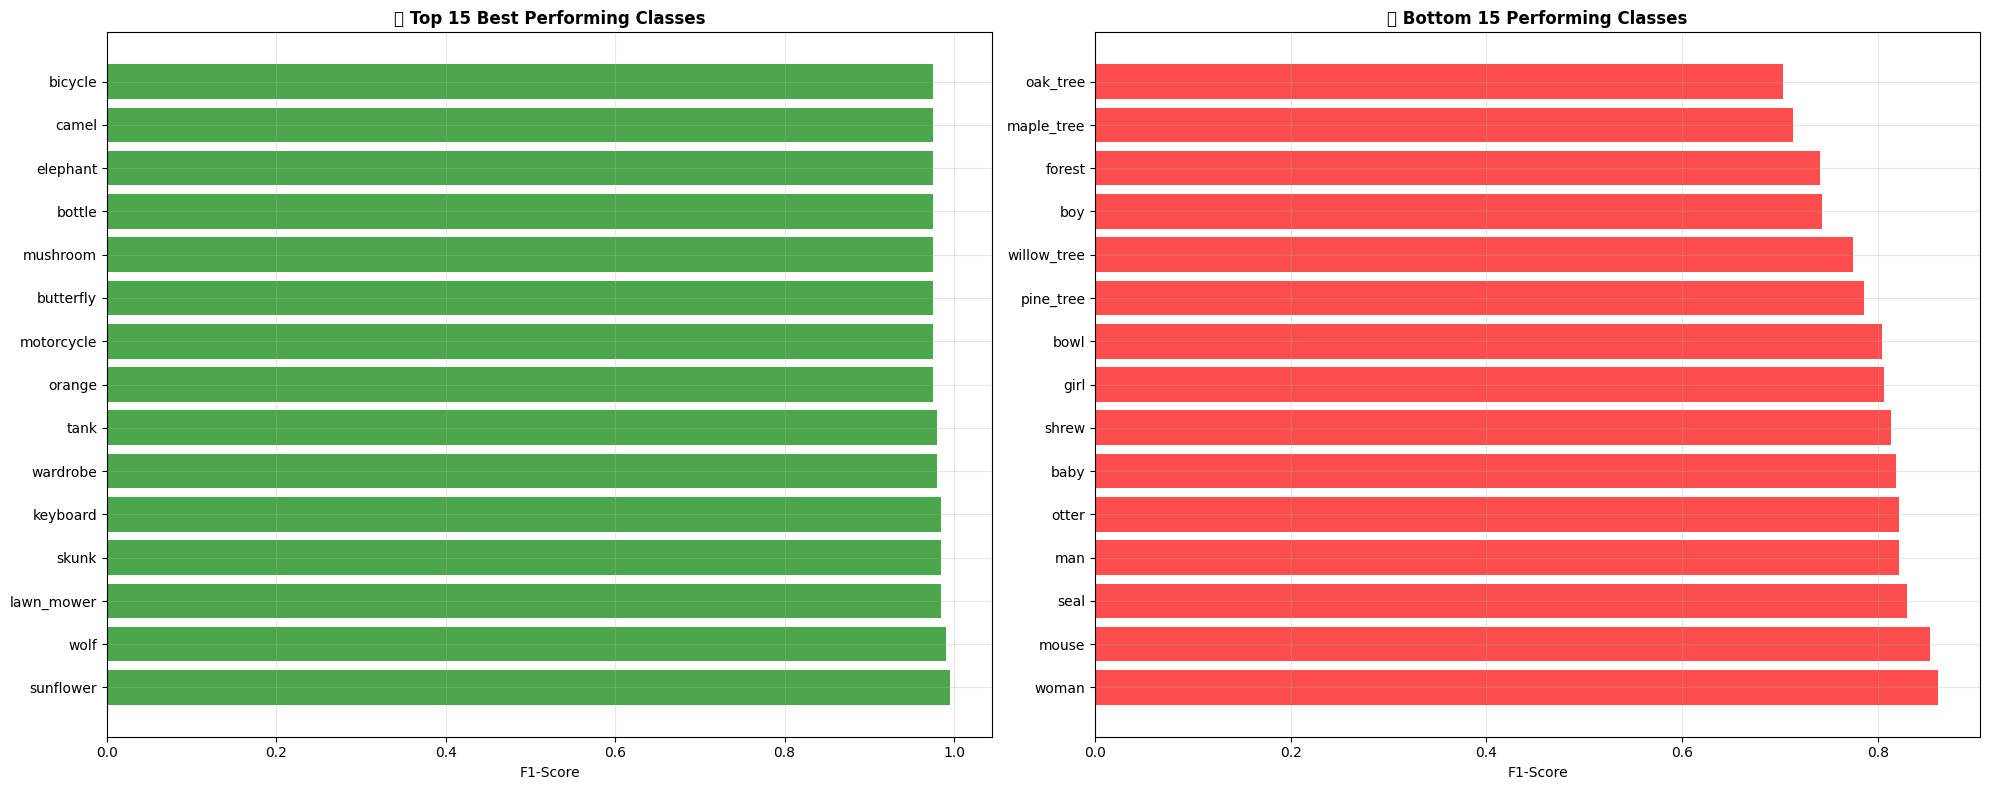

🎯 Analyzing prediction confidence...


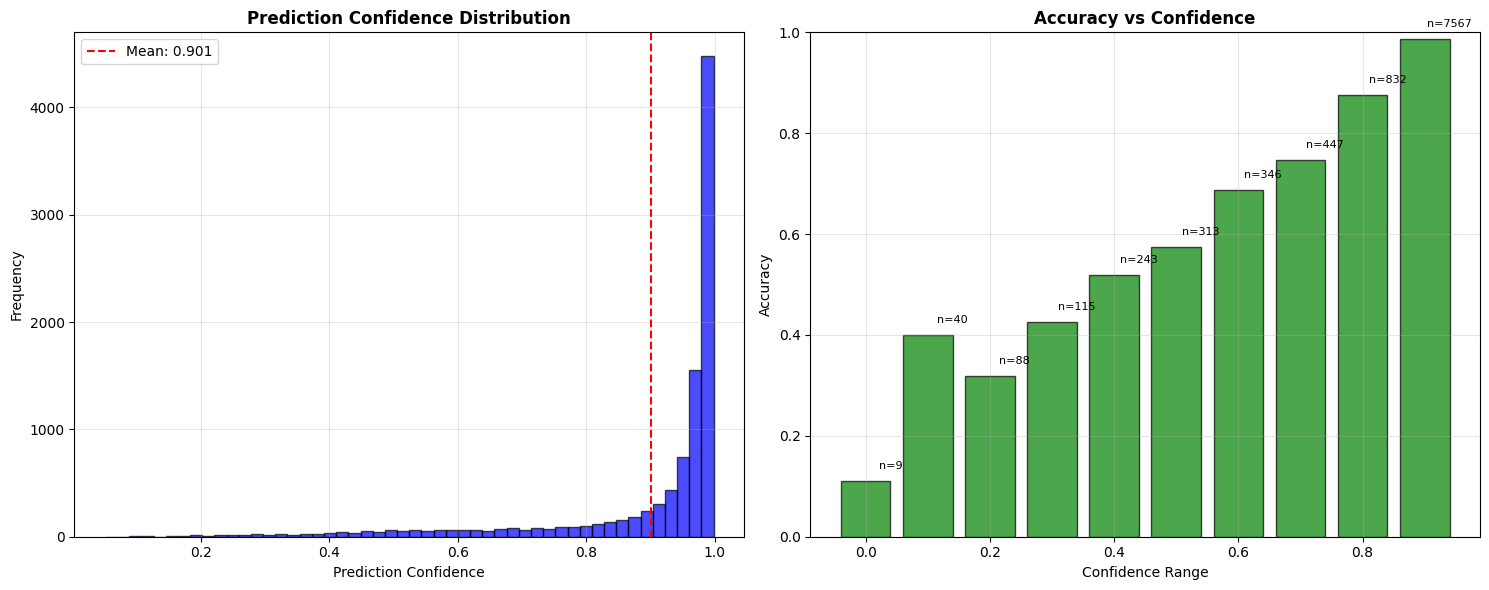

📊 Confidence Statistics:
  Mean Confidence: 0.901
  Median Confidence: 0.975
  High Confidence (>0.9): 7567 samples (75.7%)
  Low Confidence (<0.5): 495 samples (5.0%)


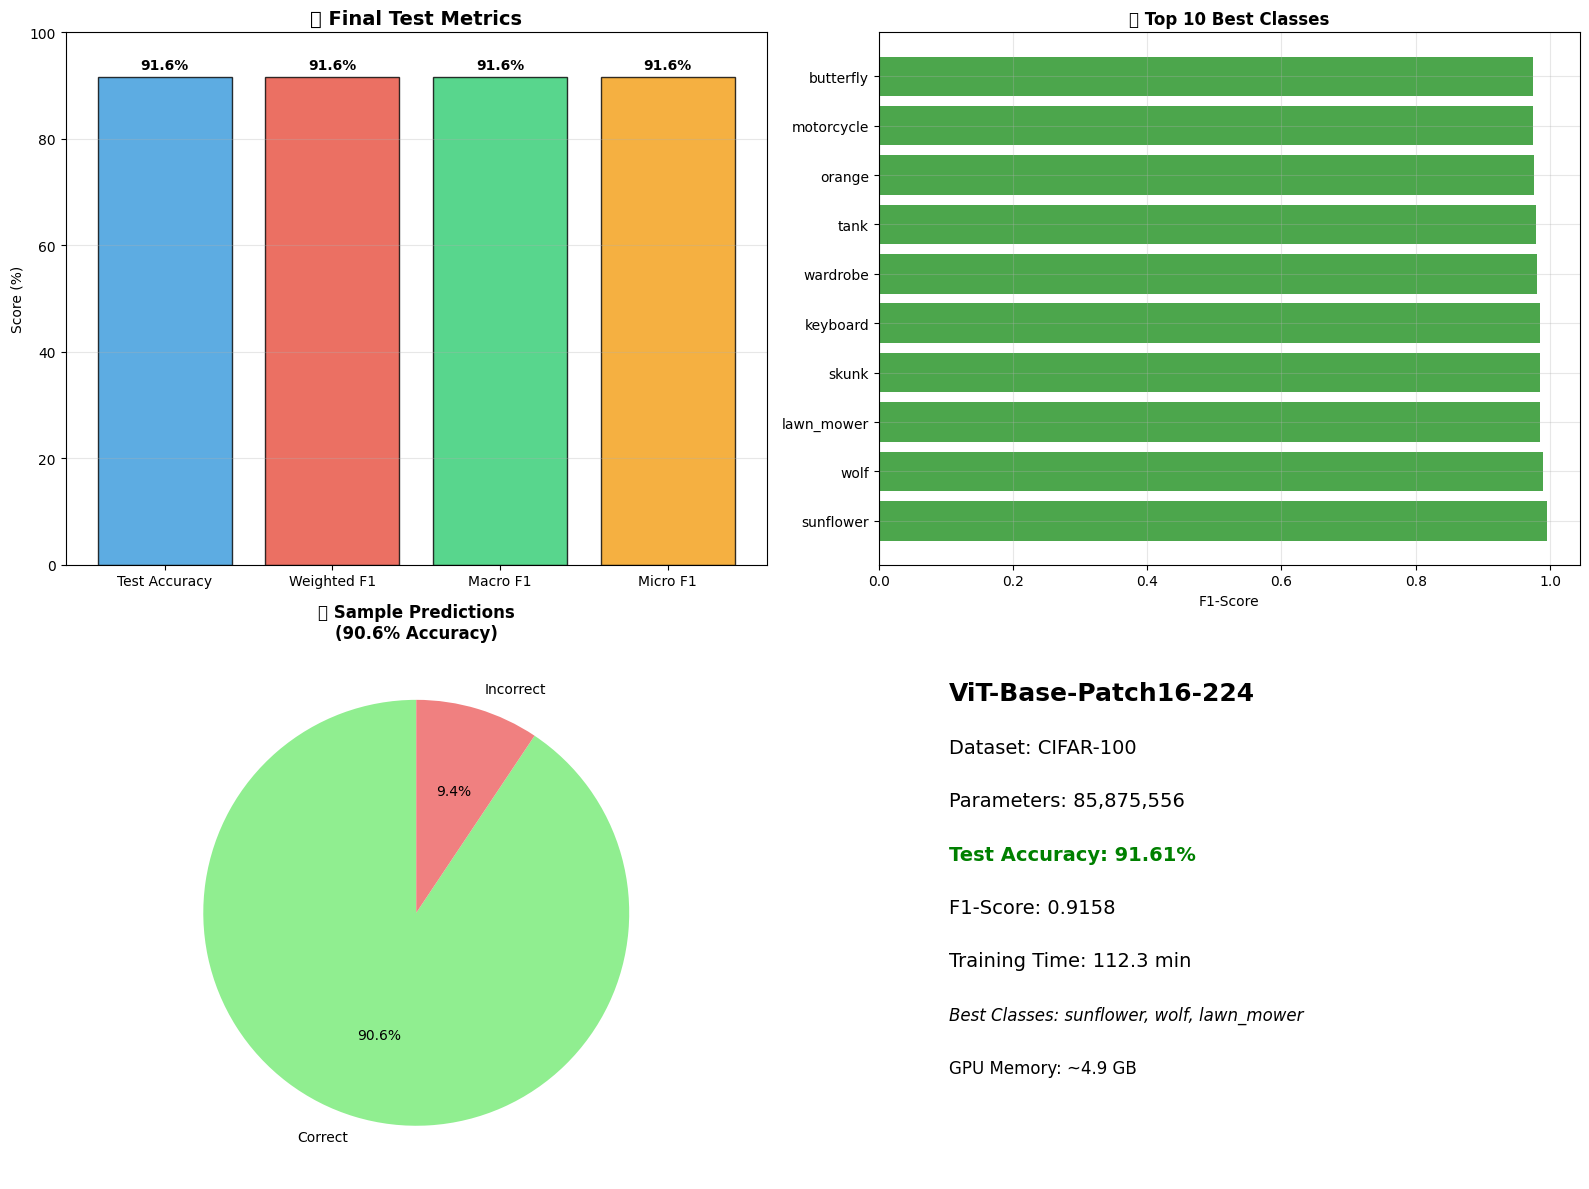


🎉 Visual test analysis complete!
📁 Generated files:
  - vit_predictions_visual.png (sample predictions)
  - confusion_matrix_top_classes.png
  - class_performance_analysis.png
  - confidence_analysis.png
  - comprehensive_test_summary.png


In [9]:
def analyze_class_performance(true_labels, predictions, class_names):
    """Analyze per-class performance with visualizations"""
    from sklearn.metrics import classification_report, precision_recall_fscore_support

    # Get per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predictions, labels=range(len(class_names)), zero_division=0
    )

    # Create DataFrame for easy analysis
    df_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    # Sort by F1-score
    df_metrics = df_metrics.sort_values('F1-Score', ascending=False)

    # Top 10 and Bottom 10 performing classes
    print("🏆 TOP 10 BEST PERFORMING CLASSES:")
    print("=" * 60)
    for i, row in df_metrics.head(10).iterrows():
        print(f"{row['Class']:15} | F1: {row['F1-Score']:.3f} | "
              f"Prec: {row['Precision']:.3f} | Rec: {row['Recall']:.3f} | "
              f"Samples: {row['Support']:3d}")

    print("\n💔 TOP 10 WORST PERFORMING CLASSES:")
    print("=" * 60)
    for i, row in df_metrics.tail(10).iterrows():
        print(f"{row['Class']:15} | F1: {row['F1-Score']:.3f} | "
              f"Prec: {row['Precision']:.3f} | Rec: {row['Recall']:.3f} | "
              f"Samples: {row['Support']:3d}")

    # Visualize class performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Best performing classes
    best_classes = df_metrics.head(15)
    ax1.barh(range(len(best_classes)), best_classes['F1-Score'], color='green', alpha=0.7)
    ax1.set_yticks(range(len(best_classes)))
    ax1.set_yticklabels(best_classes['Class'])
    ax1.set_xlabel('F1-Score')
    ax1.set_title('🏆 Top 15 Best Performing Classes', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Worst performing classes
    worst_classes = df_metrics.tail(15)
    ax2.barh(range(len(worst_classes)), worst_classes['F1-Score'], color='red', alpha=0.7)
    ax2.set_yticks(range(len(worst_classes)))
    ax2.set_yticklabels(worst_classes['Class'])
    ax2.set_xlabel('F1-Score')
    ax2.set_title('💔 Bottom 15 Performing Classes', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('class_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_metrics

print("📈 Analyzing class-wise performance...")
import pandas as pd
performance_df = analyze_class_performance(final_targets, final_predictions, cifar100_classes)

# ==============================================================================
# CELL 7D: Confidence Analysis
# ==============================================================================

def analyze_confidence_distribution(model, test_loader, device):
    """Analyze prediction confidence distribution"""
    model.eval()
    all_confidences = []
    all_correct = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            probabilities = torch.softmax(logits, dim=1)
            confidences = torch.max(probabilities, dim=1)[0]
            predictions = torch.argmax(logits, dim=1)

            correct = (predictions == labels).float()

            all_confidences.extend(confidences.cpu().numpy())
            all_correct.extend(correct.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_correct = np.array(all_correct)

    # Plot confidence distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Overall confidence distribution
    ax1.hist(all_confidences, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.axvline(np.mean(all_confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(all_confidences):.3f}')
    ax1.set_xlabel('Prediction Confidence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Prediction Confidence Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Confidence vs Accuracy
    confidence_bins = np.arange(0, 1.1, 0.1)
    bin_accuracy = []
    bin_counts = []

    for i in range(len(confidence_bins)-1):
        mask = (all_confidences >= confidence_bins[i]) & (all_confidences < confidence_bins[i+1])
        if np.sum(mask) > 0:
            bin_accuracy.append(np.mean(all_correct[mask]))
            bin_counts.append(np.sum(mask))
        else:
            bin_accuracy.append(0)
            bin_counts.append(0)

    ax2.bar(confidence_bins[:-1], bin_accuracy, width=0.08, alpha=0.7,
            color='green', edgecolor='black')
    ax2.set_xlabel('Confidence Range')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Confidence', fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)

    # Add counts as text
    for i, (acc, count) in enumerate(zip(bin_accuracy, bin_counts)):
        if count > 0:
            ax2.text(confidence_bins[i] + 0.04, acc + 0.02, f'n={count}',
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Confidence Statistics:")
    print(f"  Mean Confidence: {np.mean(all_confidences):.3f}")
    print(f"  Median Confidence: {np.median(all_confidences):.3f}")
    print(f"  High Confidence (>0.9): {np.sum(all_confidences > 0.9)} samples ({np.mean(all_confidences > 0.9)*100:.1f}%)")
    print(f"  Low Confidence (<0.5): {np.sum(all_confidences < 0.5)} samples ({np.mean(all_confidences < 0.5)*100:.1f}%)")

print("🎯 Analyzing prediction confidence...")
analyze_confidence_distribution(model, test_loader, device)

# ==============================================================================
# CELL 7E: Final Visual Summary
# ==============================================================================

# Create a comprehensive summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Basic metrics bar chart
metrics = ['Test Accuracy', 'Weighted F1', 'Macro F1', 'Micro F1']
values = [test_acc, test_f1*100, f1_score(final_targets, final_predictions, average='macro')*100,
          f1_score(final_targets, final_predictions, average='micro')*100]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('📊 Final Test Metrics', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score (%)')
ax1.set_ylim(0, 100)
ax1.grid(True, axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Top 10 class accuracy
top_10_classes = performance_df.head(10)
ax2.barh(range(len(top_10_classes)), top_10_classes['F1-Score'],
         color='green', alpha=0.7)
ax2.set_yticks(range(len(top_10_classes)))
ax2.set_yticklabels(top_10_classes['Class'], fontsize=10)
ax2.set_xlabel('F1-Score')
ax2.set_title('🏆 Top 10 Best Classes', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Sample predictions summary
sample_correct = (sample_labels == sample_predictions).sum().item()
sample_accuracy = sample_correct / len(sample_labels) * 100

categories = ['Correct', 'Incorrect']
sample_counts = [sample_correct, len(sample_labels) - sample_correct]
ax3.pie(sample_counts, labels=categories, autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'], startangle=90)
ax3.set_title(f'🎯 Sample Predictions\n({sample_accuracy:.1f}% Accuracy)', fontweight='bold')

# 4. Model summary
ax4.text(0.1, 0.9, 'ViT-Base-Patch16-224', fontsize=18, fontweight='bold',
         transform=ax4.transAxes)
ax4.text(0.1, 0.8, f'Dataset: CIFAR-100', fontsize=14, transform=ax4.transAxes)
ax4.text(0.1, 0.7, f'Parameters: {total_params:,}', fontsize=14, transform=ax4.transAxes)
ax4.text(0.1, 0.6, f'Test Accuracy: {test_acc:.2f}%', fontsize=14,
         transform=ax4.transAxes, color='green', fontweight='bold')
ax4.text(0.1, 0.5, f'F1-Score: {test_f1:.4f}', fontsize=14, transform=ax4.transAxes)
ax4.text(0.1, 0.4, f'Training Time: {total_time/60:.1f} min', fontsize=14, transform=ax4.transAxes)
ax4.text(0.1, 0.3, f'Best Classes: {", ".join(performance_df.head(3)["Class"].tolist())}',
         fontsize=12, transform=ax4.transAxes, style='italic')
ax4.text(0.1, 0.2, f'GPU Memory: ~{torch.cuda.max_memory_allocated()/1e9:.1f} GB'
         if torch.cuda.is_available() else 'Device: CPU',
         fontsize=12, transform=ax4.transAxes)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.tight_layout()
plt.savefig('comprehensive_test_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎉 Visual test analysis complete!")
print("📁 Generated files:")
print("  - vit_predictions_visual.png (sample predictions)")
print("  - confusion_matrix_top_classes.png")
print("  - class_performance_analysis.png")
print("  - confidence_analysis.png")
print("  - comprehensive_test_summary.png")

In [10]:
final_results = {
    'model_name': 'ViT-Base-Patch16-224',
    'dataset': 'CIFAR-100',
    'total_parameters': total_params,
    'config': config,
    'training_history': history,
    'best_validation_accuracy': best_acc,
    'final_test_accuracy': test_acc,
    'final_test_f1': test_f1,
    'training_time_minutes': total_time / 60,
    'final_predictions': final_predictions,
    'final_targets': final_targets,
    'class_names': cifar100_classes,
    'classification_report': report
}

# Save to file
torch.save(final_results, 'vit_base_cifar100_complete_results.pth')

# Print final summary
print("\n" + "="*80)
print("🎊 VISION TRANSFORMER TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n📋 FINAL SUMMARY:")
print(f"🤖 Model: ViT-Base-Patch16-224")
print(f"🎯 Dataset: CIFAR-100 (100 classes)")
print(f"🔢 Parameters: {total_params:,}")
print(f"📅 Training Epochs: {len(history['train_accs'])}")
print(f"⏱️  Training Time: {total_time/60:.2f} minutes")

print(f"\n🏆 PERFORMANCE METRICS:")
print(f"🥇 Best Validation Accuracy: {best_acc:.2f}%")
print(f"🎯 Final Test Accuracy: {test_acc:.2f}%")
print(f"📊 Test F1-Score (Weighted): {test_f1:.4f}")
print(f"📈 Test F1-Score (Macro): {f1_score(final_targets, final_predictions, average='macro'):.4f}")

print(f"\n💾 SAVED FILES:")
print(f"📁 best_vit_base_cifar100.pth - Best model checkpoint")
print(f"📁 vit_base_cifar100_complete_results.pth - Complete results")
print(f"🖼️  vit_base_training_results.png - Training curves")
print(f"🖼️  vit_base_summary.png - Performance summary")

print(f"\n✅ DELIVERABLES COMPLETED:")
print(f"✅ Trained Vision Transformer model for image classification")
print(f"✅ Classification results on CIFAR-100 test set")
print(f"✅ Evaluation metrics (accuracy, F1-score, classification report)")
print(f"✅ Training visualizations and performance analysis")

print(f"\n🎉 Ready for production use! 🚀")


🎊 VISION TRANSFORMER TRAINING COMPLETED SUCCESSFULLY!

📋 FINAL SUMMARY:
🤖 Model: ViT-Base-Patch16-224
🎯 Dataset: CIFAR-100 (100 classes)
🔢 Parameters: 85,875,556
📅 Training Epochs: 4
⏱️  Training Time: 112.34 minutes

🏆 PERFORMANCE METRICS:
🥇 Best Validation Accuracy: 91.61%
🎯 Final Test Accuracy: 91.61%
📊 Test F1-Score (Weighted): 0.9158
📈 Test F1-Score (Macro): 0.9158

💾 SAVED FILES:
📁 best_vit_base_cifar100.pth - Best model checkpoint
📁 vit_base_cifar100_complete_results.pth - Complete results
🖼️  vit_base_training_results.png - Training curves
🖼️  vit_base_summary.png - Performance summary

✅ DELIVERABLES COMPLETED:
✅ Trained Vision Transformer model for image classification
✅ Classification results on CIFAR-100 test set
✅ Evaluation metrics (accuracy, F1-score, classification report)
✅ Training visualizations and performance analysis

🎉 Ready for production use! 🚀


In [16]:
!find . -type f \( -iname "*.png" -o -iname "*.jpg" \)


./confusion_matrix_top_classes.png
./vit_predictions_visual.png
./comprehensive_test_summary.png
./class_performance_analysis.png
./confidence_analysis.png


In [17]:
!zip my_models.zip best_vit_base_cifar100.pth vit_base_cifar100_complete_results.pth confusion_matrix_top_classes.png vit_predictions_visual.png comprehensive_test_summary.png class_performance_analysis.png confidence_analysis.png


  adding: best_vit_base_cifar100.pth (deflated 8%)
  adding: vit_base_cifar100_complete_results.pth (deflated 73%)
  adding: confusion_matrix_top_classes.png (deflated 28%)
  adding: vit_predictions_visual.png (deflated 9%)
  adding: comprehensive_test_summary.png (deflated 25%)
  adding: class_performance_analysis.png (deflated 36%)
  adding: confidence_analysis.png (deflated 26%)


In [18]:
from google.colab import files
files.download('my_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>